In [1]:
import torch
from torch import nn
import copy
import numpy as np
import matplotlib.pyplot as plt
from dataset import get_cifar10
from model import ResNet20, ResNet20_Quant

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
train_loader, _, test_loader = get_cifar10(transform_train=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def test(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    test_acc = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
        
            data = data.to(device)
            target = target.to(device)
        
            output = model(data)

            predictions = output.data.max(1)[1]
            test_acc += predictions.eq(target).sum().item()

        test_acc = test_acc / len(test_loader.dataset)
    return test_acc

# Загрузка модели оценка Pytorch Quantization

In [5]:
unquantized_model = ResNet20_Quant(3, 10)

# Weights for ResNet20 are compatible with ResNet20_Quant
unquantized_model.load_state_dict(torch.load('best_model', map_location=torch.device('cpu')))

# Torch observers support different quantization ranges, but they can only use 8-bit integers

# qconf = torch.quantization.QConfig(activation=torch.quantization.MinMaxObserver.with_args(quant_min=-128, quant_max=127),
# weight=torch.quantization.default_observer.with_args(quant_min=-128, quant_max=127, dtype=torch.qint8))
unquantized_model.qconfig =  torch.quantization.get_default_qconfig('fbgemm')

prepared_model = torch.quantization.prepare(unquantized_model, inplace=False)

D:\Anaconda\lib\site-packages\torch\quantization\observer.py:124: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


In [6]:
# Collect activation stats
for batch_idx, (data, target) in enumerate(train_loader):
    prepared_model(data)
    if batch_idx == 20:
        break

In [7]:
quantized_model_torch = torch.quantization.convert(prepared_model)

D:\Anaconda\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [8]:
unquantized_model

ResNet20_Quant(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (ff1): FloatFunctional(
    (activation_post_process): Identity()
  )
  (ff2): FloatFunctional(
    (activation_post_process): Identity()
  )
  (ff3): FloatFunctional(
    (activation_post_process): Identity()
  )
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU()
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convs): ModuleList(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding

In [9]:
quantized_model_torch

ResNet20_Quant(
  (quant): Quantize(scale=tensor([0.0374]), zero_point=tensor([57]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (ff1): QFunctional(
    scale=0.750614583492279, zero_point=62
    (activation_post_process): Identity()
  )
  (ff2): QFunctional(
    scale=0.404750794172287, zero_point=66
    (activation_post_process): Identity()
  )
  (ff3): QFunctional(
    scale=0.7586240172386169, zero_point=49
    (activation_post_process): Identity()
  )
  (conv1): QuantizedConv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), scale=2.115269422531128, zero_point=59, padding=(1, 1), bias=False)
  (relu): ReLU()
  (bn1): QuantizedBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convs): ModuleList(
    (0): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=29.722116470336914, zero_point=67, padding=(1, 1), bias=False)
    (1): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=22.889385223388672, zero_point=60, padding=(1, 1)

In [10]:
unquantized_score = test(unquantized_model, test_loader)
torch_score = test(quantized_model_torch, test_loader)
print('Unquantized model test accuracy: ', unquantized_score)
print('Torch quantized model (8 bits) test accuracy: ', torch_score)

Unquantized model test accuracy:  0.8983
Torch quantized model (8 bits) test accuracy:  0.8481


# Реализация квантизации

В своей реализации PTQ я собираю статистику активаций с помощью метода `.get_statistics()`, сохраняющего активации выходы на каждом слое в словарь. Затем я беру модель, квантизированную Pytorch, и заменяю на всех слоях `scale` и `zero_point` на посчитанные с помощью собранной статистики (функция `requantize_outputs()`). Также для `Linear` и `Conv2d` слоев квантизируются веса (функция `requantize_weights()`). 

## Определение функций для квантизации

In [11]:
def requantize_outputs(original_model, quantized_model, outputs_dict, n_bits):
    with torch.no_grad():
        # Torch wants unsigned ints here
        q_min = 0
        q_max = 2**n_bits - 1
        
        for idx, (module_orig, module_q) in enumerate(zip(original_model.modules(), quantized_model.modules())):
            if module_orig not in outputs_dict:
                continue

            mins = [out.numpy().min() for out in outputs_dict[module_orig]]
            maxs = [out.numpy().max() for out in outputs_dict[module_orig]]
            
            min_val, max_val = np.min(mins), np.max(maxs)
            scale = (max_val - min_val) / (q_max - q_min)
            zero = q_min - round(min_val / scale)
            zero = np.clip(zero, q_min, q_max)

            module_q.scale = torch.tensor(scale)
            module_q.zero_point = torch.tensor(zero)

In [12]:
def requantize_weights(original_model, quantized_model, n_bits):
    with torch.no_grad():
        # Torch wants signed ints here
        q_min = -(2 ** (n_bits - 1))
        q_max = 2 ** (n_bits - 1) - 1
        
        for module_orig, module_q in zip(original_model.modules(), quantized_model.modules()):
            if isinstance(module_orig, nn.Linear) or isinstance(module_orig, nn.Conv2d):
                weights = module_orig.weight.numpy()
                
                min_val = weights.min()
                max_val = weights.max()
                
                scale = (max_val - min_val) / (q_max - q_min)
                zero = q_min - np.round(min_val / scale)
                zero = np.clip(zero, q_min, q_max).astype(int)
                
                # it uses 8-bit integer but because of q_min and q_max its values will be in range of n_bits int
                # torch simply doesn't support any smaller ints than qint8
                quantized_weights = torch.quantize_per_tensor(module_orig.weight, scale, zero, dtype=torch.qint8)

                # torch doesn't quantize bias
                module_q.set_weight_bias(quantized_weights, module_orig.bias)


In [13]:
def requantize_model(original_model, quantized_model, outputs_dict, n_bits):
    requantize_outputs(original_model, quantized_model, outputs_dict, n_bits)
    requantize_weights(original_model, quantized_model, n_bits)

In [14]:
def get_stats(model, data_loader, n_batches=20):
    outputs_dict = {}

    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.BatchNorm2d) or \
           isinstance(module, nn.Linear) or isinstance(module, torch.quantization.QuantStub) or \
           isinstance(module, torch.nn.quantized.FloatFunctional):
            outputs_dict[module] = []
    
    # On each iteration the outputs are appended to the list
    for batch_idx, (data, target) in enumerate(data_loader):
        model.get_statistics(data, outputs_dict)
        if batch_idx == n_batches:
            break
    return outputs_dict

## Сбор статистики

In [15]:
outputs_dict = get_stats(unquantized_model, train_loader)

## Создание квантизированной модели

У меня не получилось скопировать модель полученную Pytorch, поэтому я меняю исходную. И `copy.deepcopy()`, и `torch.save() torch.load()` теряли часть аттрибутов.

In [16]:
# this should be copying
quantized_model_my = quantized_model_torch

In [17]:
requantize_model(unquantized_model, quantized_model_my, outputs_dict, 8)

In [18]:
my_score = test(quantized_model_my, test_loader)
print('Unquantized model test accuracy: ', unquantized_score)
print('Torch quantized model (8 bits) test accuracy: ', torch_score)
print('My quantized model (8 bits) test accuracy: ', my_score)

Unquantized model test accuracy:  0.8983
Torch quantized model (8 bits) test accuracy:  0.8481
My quantized model (8 bits) test accuracy:  0.8511


Моя реализация показывает чуть большую точность, чем Pytorch. Основное отличие Pytorch в том, что он использует `HistogramObserver` для сбора статистики, который считает `scale` и `zero_point` на основе распределения данных, а не только минимума и максимума. Возможно, из-за относительно небольшого количества примеров, на которых собиралась статистика (20 батчей по 128 изображений), его распределение получилось недостаточно репрезентативно. Влияние количества калибрационных данных на точность будет исследована ниже.

## Влияние количества бит квантизации на точность

Pytorch поддерживает только 8-битные инты для квантизации, так что для 16 бит результата не имею. Но и при 8 битах точность близка к исходной так что ничего интересного не упущено. 

In [19]:
test_scores = []
for n_bits in [2, 4, 8]:
    requantize_model(unquantized_model, quantized_model_my, outputs_dict, n_bits)
    test_scores.append(test(quantized_model_my, test_loader))

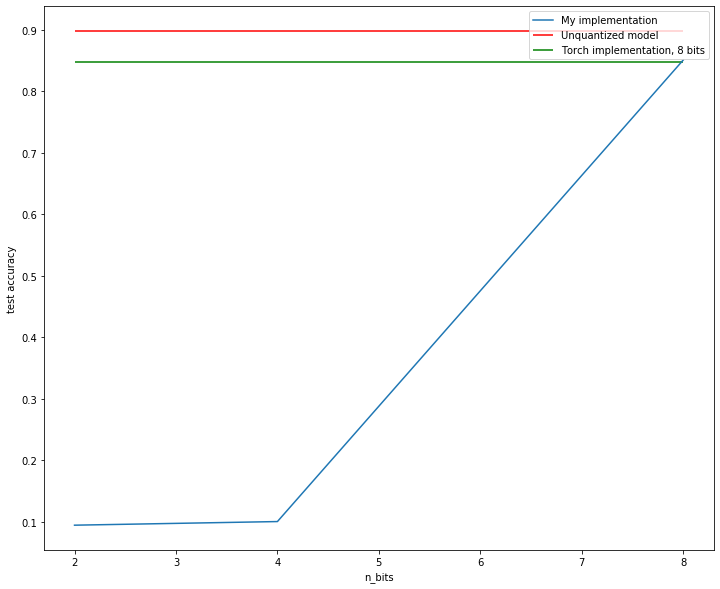

In [20]:
plt.figure(figsize=(12,10))
plt.plot([2, 4, 8], test_scores, label='My implementation')
plt.hlines(unquantized_score, 2, 8, label='Unquantized model', color='red')
plt.hlines(torch_score, 2, 8, label='Torch implementation, 8 bits', color='green')
plt.xlabel('n_bits')
plt.ylabel('test accuracy')
plt.legend()

Уменьшение количества бит ожидаемо негативно сказывается на точности. Крайний случай - 2 бита - позволяет представить всего четыре различных значения, что меньше, чем количество классов в датасете (Так как выходы последнего слоя квантизированы, модель может предсказать только 4 класса из 10). 

При 4 битах точность хуже, чем я ожидал. Похоже, 16 чисел тоже недостаточно, чтобы  передать основные нюансы.

## Влияние трансформаций калибрационных данных на точность

При обучении модели трансформация данных позволяет получить более разнообразный датасет и повысить точность модели. Для квантизации важна репрезентативность данных, а не их разнообразие, но все же стоит провести эмпирический тест

In [21]:
train_loader_transformed, _, _ = get_cifar10(transform_train=True)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
outputs_dict_transformed = get_stats(unquantized_model, train_loader_transformed)
test_scores_transformed = []
for n_bits in [2, 4, 8]:
    requantize_model(unquantized_model, quantized_model_my, outputs_dict_transformed, n_bits)
    test_scores_transformed.append(test(quantized_model_my, test_loader))

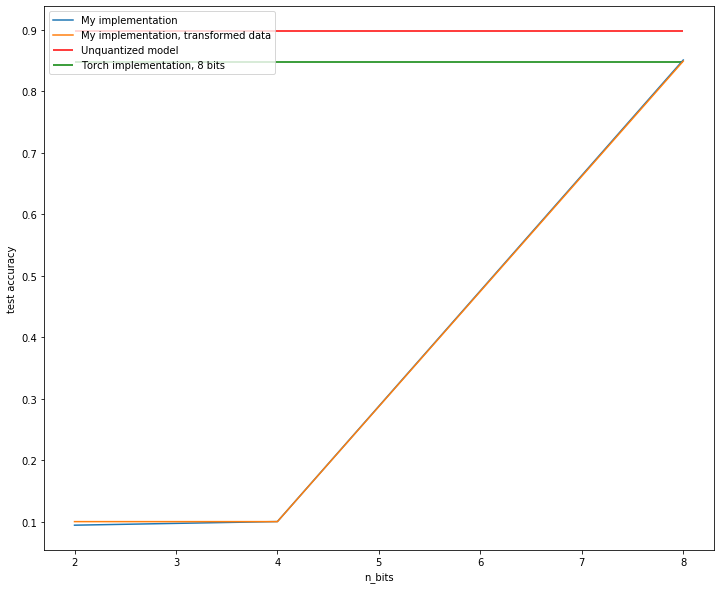

In [23]:
plt.figure(figsize=(12,10))
plt.plot([2, 4, 8], test_scores, label='My implementation')
plt.plot([2, 4, 8], test_scores_transformed, label='My implementation, transformed data')
plt.hlines(unquantized_score, 2, 8, label='Unquantized model', color='red')
plt.hlines(torch_score, 2, 8, label='Torch implementation, 8 bits', color='green')
plt.xlabel('n_bits')
plt.ylabel('test accuracy')
plt.legend()

Трансформация данных ухудшила точность для двух битов и оставила примерно без изменений для остальных значений. Вероятно, большая часть результата определяется квантизацией весов, которая не зависит от калибровочных данных.

## Влияние количества каблибрационных данных на точность

In [24]:
batch_scores = []
for n_batches in [1, 2, 5, 10]:
    outputs_dict = get_stats(unquantized_model, train_loader, n_batches)
    test_scores_batch = []
    for n_bits in [4, 8]:
        requantize_model(unquantized_model, quantized_model_my, outputs_dict, n_bits)
        test_scores_batch.append(test(quantized_model_my, test_loader))
    batch_scores.append(test_scores_batch)
    
# for n_batches = 20
batch_scores.append(test_scores[1:])

In [25]:
batch_scores[-1][-1]

0.8511

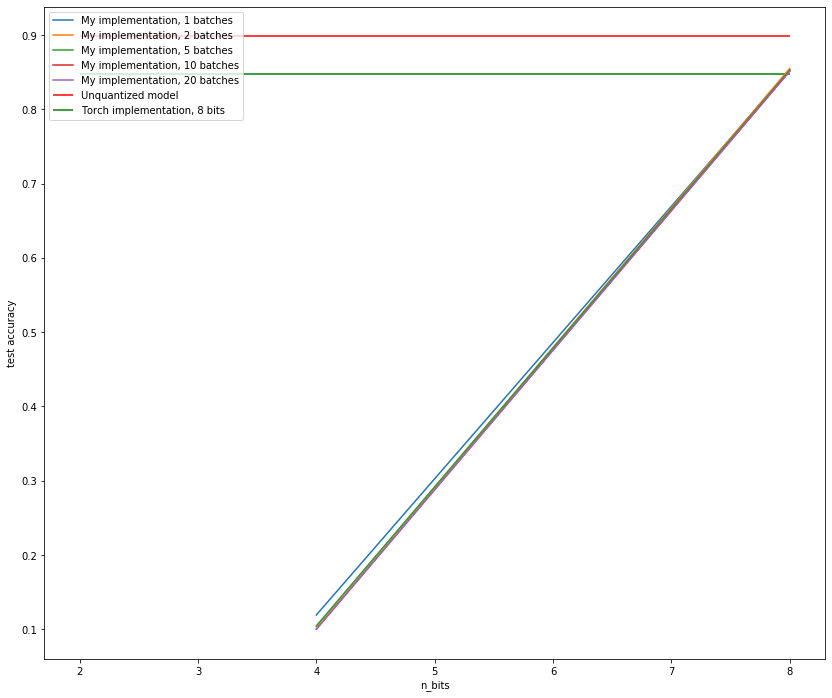

In [26]:
plt.figure(figsize=(14,12))
plt.hlines(unquantized_score, 2, 8, label='Unquantized model', color='red')
plt.hlines(torch_score, 2, 8, label='Torch implementation, 8 bits', color='green')
for n_batches, batch_score in zip([1, 2, 5, 10, 20], batch_scores):
    plt.plot([4, 8], batch_score, label=f'My implementation, {n_batches} batches')
plt.xlabel('n_bits')
plt.ylabel('test accuracy')
plt.legend()

1 батч показываtт лучший результат. Возможно, в этот батч попали данные, больше всего похожие на тестовый сет. То, что результаты для 8 бит очень близки, подтверждает, что основной вклад вносит квантизация весов.

На всякий случай проверим, как ведет себя Pytorch

In [27]:
torch_batch_scores = []
for n_batches in [1, 2, 5, 10, 20, 40, 60, 100]:
    unquantized_model = ResNet20_Quant(3, 10)

    # Weights for ResNet20 are compatible with ResNet20_Quant
    unquantized_model.load_state_dict(torch.load('best_model', map_location=torch.device('cpu')))

    # Torch observers support different quantization ranges, but they can only use 8-bit integers

    # qconf = torch.quantization.QConfig(activation=torch.quantization.MinMaxObserver.with_args(quant_min=-128, quant_max=127),
    # weight=torch.quantization.default_observer.with_args(quant_min=-128, quant_max=127, dtype=torch.qint8))
    unquantized_model.qconfig =  torch.quantization.get_default_qconfig('fbgemm')
    
    prepared_model = torch.quantization.prepare(unquantized_model, inplace=False)

    # Collect activation stats
    for batch_idx, (data, target) in enumerate(train_loader):
        prepared_model(data)
        if batch_idx == n_batches:
            break

    quantized_model_torch = torch.quantization.convert(prepared_model)
    torch_batch_scores.append(test(quantized_model_torch, test_loader))

D:\Anaconda\lib\site-packages\torch\quantization\observer.py:124: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


Text(0, 0.5, 'test accuracy')

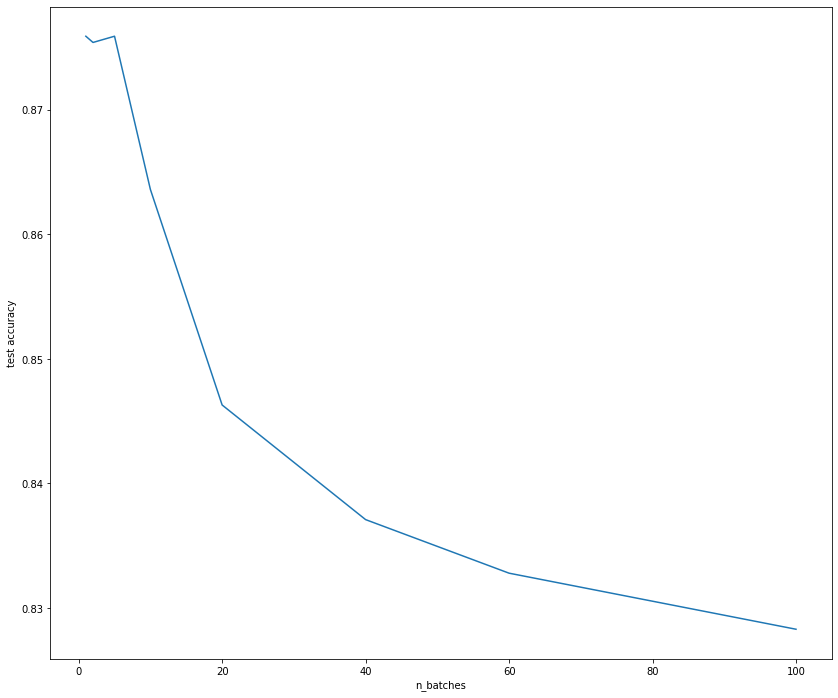

In [28]:
plt.figure(figsize=(14,12))
plt.plot([1, 2, 5, 10, 20, 40, 60, 100], torch_batch_scores)
plt.xlabel('n_batches')
plt.ylabel('test accuracy')

Поведение аналогичное. При малом количестве батчей точность высокая, лучше чем моей реализации, но быстро падает с увеличением количества батчей

# Пути улучшения

Мою реализацию можно улучшить, используя более качественные методы рассчета `scale` и `zero_point`, например как в `HistogramObserver`. Также в моей реализации сохраняются все тензоры, хотя используются только минимум и максимум. Можно оптимизировать сбор статистики, оставляя только нужную информацию после каждой итерации.

В целом улучшить метод квантизации можно за счет неравномерного разбиения диапазона. Сейчас интервал между минимумом и максимумом бьется на равные подинтервалы. Но распределение значений может быть неравномерным, например больше группироваться у краев интервала. Тогда было бы полезнее иметь большее разрешение по краям и меньшее в центре.